## ResNet50 with DAiSEE: Preprocessing, Balancing, Training & Evaluation
#### By: Tan Jun Lin (160989)

Description: 
- This script preprocesses video clips into frames, balances the dataset, trains a ResNet50 model using Focal Loss, and evaluates performance on real-world data.

### 1. Import necessary libraries and paths

In [ ]:
# Import common libraries
import os
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Import data preprocessing libraries
import concurrent.futures
import shutil
import cv2
import multiprocessing as mp
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

# Model Training Libraries
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization, ReLU
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import CosineDecayRestarts
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.losses import CategoricalFocalCrossentropy
from tensorflow.keras.metrics import Precision, Recall

# Evaluation Libraries
from sklearn.metrics import classification_report, confusion_matrix, recall_score


# block warning libraries
import warnings 
warnings.simplefilter(action='ignore', category=FutureWarning)

In [45]:
# Declare all the necessary paths
BASE_DIR = os.getcwd()
DATA_DIR = os.path.join(BASE_DIR, 'data')
MODEL_DIR = os.path.join(BASE_DIR, 'models')

# Paths that that store in data
LABELS_DIR = os.path.join(DATA_DIR, 'raw/Labels')
DATASET_DIR = os.path.join(DATA_DIR, 'raw/DataSet')
PROCESSED_DATA_DIR = os.path.join(DATA_DIR, 'processed')
BALANCED_DIR = os.path.join(DATA_DIR, "balance_processed")

LABEL_FILES = {
        'Train': os.path.join(LABELS_DIR, 'TrainLabels.csv'),
        'Validation': os.path.join(LABELS_DIR, 'ValidationLabels.csv'),
        'Test': os.path.join(LABELS_DIR, 'TestLabels.csv')
    }

CASCADE_PATH = os.path.join(BASE_DIR, 'config/haarcascade_frontalface_default.xml')

# Metadata input and output that store in processed dir
INPUT_METADATA = os.path.join(PROCESSED_DATA_DIR, 'metadata.csv')
OUTPUT_METADATA = os.path.join(PROCESSED_DATA_DIR, 'balanced_metadata.csv')

# Paths that store in models
EMOTIONAL_RECOGNITION_MODEL = os.path.join(MODEL_DIR, 'emotional_recognition_model.h5')

### 2. DAiSEE Video Preprocessing & Dataset Preparation

In [ ]:
# Based on DAiSEE predefined labels, classify the classes (customized)
def map_daisee_to_attention(row):
    boredom = row["Boredom"]
    engagement = row["Engagement"]
    confusion = row["Confusion"]
    frustration = row["Frustration"]

    # If high confusion or frustration, classify as 'Lacking_Focus'
    if confusion >= 2 or frustration >= 2:
        return "Lacking_Focus"

    # If high boredom, classify as 'Bored'
    if boredom >= 2:
        return "Bored"

    # If high engagement and low other factors, classify as 'Interested'
    if engagement >= 2 and boredom <= 1 and confusion <= 1 and frustration <= 1:
        return "Interested"

    return "Lacking_Focus"

In [52]:
def detect_and_align_face_fast(image, target_size=(224, 224)):
    face_cascade = cv2.CascadeClassifier(CASCADE_PATH)
    if face_cascade.empty():
        print(f"Error: Failed to load cascade classifier from {CASCADE_PATH}")
        return None
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    if len(faces) == 0:
        return None
    x, y, w, h = max(faces, key=lambda rect: rect[2] * rect[3])
    face_img = image[max(0, y - int(h * 0.1)):y + h + int(h * 0.1), max(0, x - int(w * 0.1)):x + w + int(w * 0.1)]
    if face_img.size == 0:
        return None
    return cv2.resize(cv2.cvtColor(face_img, cv2.COLOR_BGR2RGB), target_size, interpolation=cv2.INTER_LANCZOS4)

In [ ]:
def extract_frames(video_path, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    vidcap = cv2.VideoCapture(video_path)
    if not vidcap.isOpened():
        print(f"Error: Cannot open video file: {video_path}")
        return 0
    
    total_frames = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    frame_interval = max(1, total_frames // 50)  # Ensure at most 50 frames per clip (30fps format)
    frames_to_extract = [i for i in range(0, total_frames, frame_interval)][:50]  

    frames_extracted = 0
    for frame_pos in frames_to_extract:
        vidcap.set(cv2.CAP_PROP_POS_FRAMES, frame_pos)
        success, image = vidcap.read()
        if not success:
            continue
        
        face_img = detect_and_align_face_fast(image)
        if face_img is None:
            continue
        
        frame_filename = os.path.join(output_dir, f"frame_{frames_extracted:03d}.jpg")
        cv2.imwrite(frame_filename, cv2.cvtColor(face_img, cv2.COLOR_RGB2BGR), [cv2.IMWRITE_JPEG_QUALITY, 95])
        frames_extracted += 1

    vidcap.release()
    return frames_extracted

In [150]:
def process_video_worker(args):
    row, split = args
    clip_id = row['ClipID']
    label = map_daisee_to_attention(row)
    
    if label is None:
        return None
    
    video_path = os.path.join(DATASET_DIR, split, clip_id[:6], clip_id[:-4], clip_id)
    output_folder = os.path.join(PROCESSED_DATA_DIR, split, label, clip_id[:-4])
    
    if not os.path.exists(video_path):
        return None
    
    frames_count = extract_frames(video_path, output_folder)
    return {'clip_id': clip_id, 'emotion': label, 'split': split, 'frames': frames_count, 'path': output_folder} if frames_count > 0 else None

In [153]:
def process_dataset(num_workers=None):
    if num_workers is None:
        num_workers = max(1, mp.cpu_count() - 1)
        
    print(f"Processing with {num_workers} workers...")
    metadata_list = []
    
    for split, csv_file in LABEL_FILES.items():
        print(f"Processing {split} split...")
        df = pd.read_csv(csv_file)
        args_list = [(row, split) for _, row in df.iterrows()]
        with mp.Pool(processes=num_workers) as pool:
            results = list(tqdm(pool.imap(process_video_worker, args_list), total=len(args_list)))
        valid_results = [result for result in results if result is not None]
        metadata_list.extend(valid_results)
        
    metadata_df = pd.DataFrame(metadata_list) if metadata_list else pd.DataFrame()
    
    if not metadata_df.empty:
        metadata_df.to_csv(os.path.join(PROCESSED_DATA_DIR, 'metadata.csv'), index=False)
        print("\nDataset statistics:")
        for split in metadata_df['split'].unique():
            split_df = metadata_df[metadata_df['split'] == split]
            print(f"\n{split.upper()} split:")
            print(f"Total clips: {len(split_df)}")  # Counts clips
            for emotion, count in Counter(split_df['emotion']).items():
                print(f"  {emotion}: {count}")  # Also counts clips 
                
    else:
        print("No videos were successfully processed.")

In [154]:
# Process the dataset (Extract the features and applied classified into 3 classes based on different labels that provided by DAiSEE datasets)
process_dataset()

Processing with 19 workers...
Processing Train split...


100%|██████████| 5358/5358 [1:44:38<00:00,  1.17s/it]  


Processing Validation split...


100%|██████████| 1429/1429 [22:42<00:00,  1.05it/s]


Processing Test split...


100%|██████████| 1784/1784 [31:45<00:00,  1.07s/it] 



Dataset statistics:

TRAIN split:
Total clips: 5356
  Interested: 3705
  Lacking_Focus: 684
  Bored: 967

VALIDATION split:
Total clips: 1428
  Interested: 703
  Bored: 467
  Lacking_Focus: 258

TEST split:
Total clips: 1774
  Interested: 1233
  Bored: 311
  Lacking_Focus: 230


### 3. Balancing DAiSEE Training Dataset (Customized Classes)

In [155]:
# Load metadata and read the first 5 rows
def load_metadata():
    """Loads metadata from CSV."""
    if not os.path.exists(INPUT_METADATA):
        raise FileNotFoundError("metadata.csv not found in the processed directory!")
    return pd.read_csv(INPUT_METADATA)

data_df = load_metadata()
print("Metadata Dataframe:\n", data_df.head(2))

Metadata Dataframe:
           clip_id     emotion  split  frames  \
0  1100011002.avi  Interested  Train      50   
1  1100011003.avi  Interested  Train      50   

                                                path  
0  /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/dat...  
1  /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/dat...  


In [157]:
# Split into train_df, val_df and test_df (To ensure balanced dataset, all the dataset that didnt have 50 frame will be filtered out)
# - it can be safety remove due to it occupied overall dataset ~0.6%
train_df = data_df[(data_df['split'] == 'Train') & (data_df['frames'] == 50)]
val_df = data_df[(data_df['split'] == 'Validation') & (data_df['frames'] == 50)]
test_df = data_df[(data_df['split'] == 'Test') & (data_df['frames'] == 50)]

In [158]:
# Visualize Class Distribution for Train Set only
def plot_class_distribution(df, title):
    """Plots class distribution."""
    plt.figure(figsize=(8, 4))
    sns.countplot(x='emotion', data=df, palette='viridis')
    plt.title(title)
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.show()
    
def plot_multiple_distributions(train_df, val_df, test_df):
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))  # 1 row, 3 columns

    sns.countplot(x='emotion', hue='emotion', data=train_df, palette='viridis', legend=False, ax=axes[0])
    axes[0].set_title("Train Before Balancing")
    axes[0].set_xlabel("Class")
    axes[0].set_ylabel("Count")

    sns.countplot(x='emotion', hue='emotion', data=val_df, palette='plasma', legend=False, ax=axes[1])
    axes[1].set_title("Validation Before Balancing")
    axes[1].set_xlabel("Class")

    sns.countplot(x='emotion', hue='emotion', data=test_df, palette='magma', legend=False, ax=axes[2])
    axes[2].set_title("Test Before Balancing")
    axes[2].set_xlabel("Class")

    plt.tight_layout()
    plt.show()

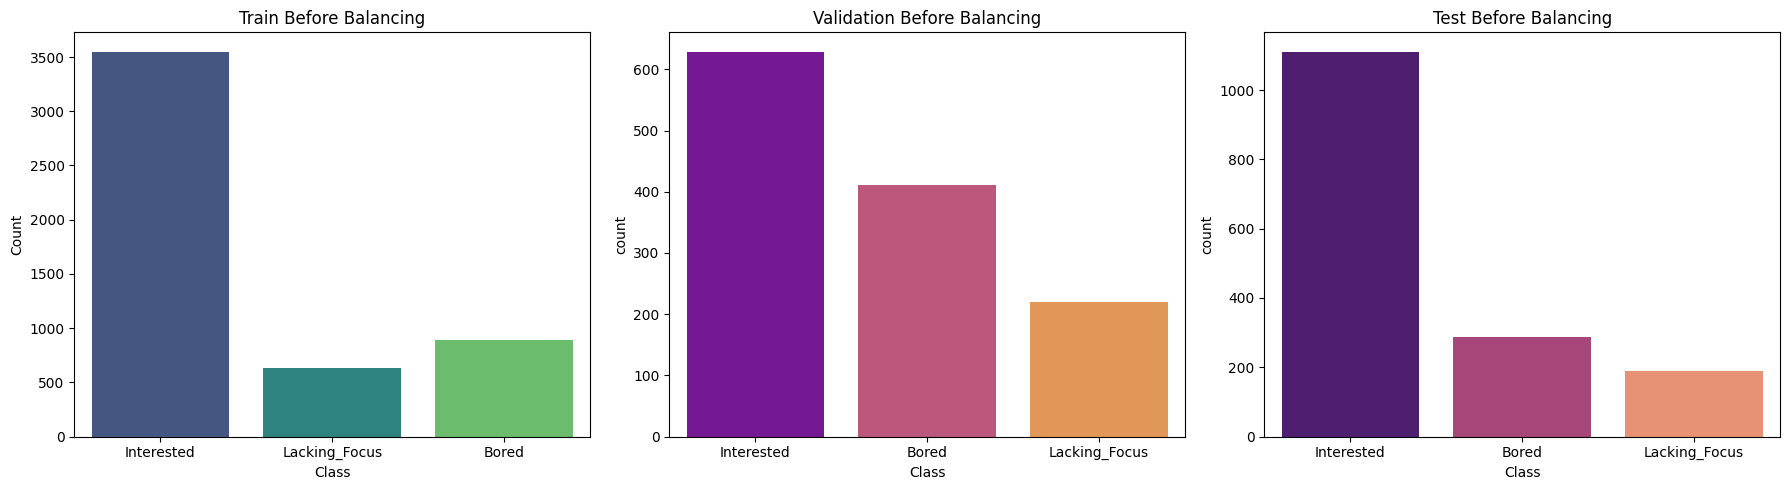

Train Class Distribution:
emotion
Interested       3550
Bored             892
Lacking_Focus     632
Name: count, dtype: int64

Validation Class Distribution:
emotion
Interested       629
Bored            411
Lacking_Focus    220
Name: count, dtype: int64

Test Class Distribution:
emotion
Interested       1111
Bored             287
Lacking_Focus     189
Name: count, dtype: int64


In [178]:
# Show the train, val and test distribution
plot_multiple_distributions(train_df, val_df, test_df)

# Check for the class split
print("Train Class Distribution:")
print(train_df["emotion"].value_counts())

print("\nValidation Class Distribution:")
print(val_df["emotion"].value_counts())

print("\nTest Class Distribution:")
print(test_df["emotion"].value_counts())

In [ ]:
# Set a target sample based on observation of the graphs
TARGET_SAMPLES_PER_CLASS = 1500 # To match with validations data

In [204]:
# Create a new DataFrame specialize for Train Dataset and compute the classes 
class_counts = Counter(train_df['emotion'])
balanced_train_df = pd.DataFrame()

In [ ]:
# Understampling Majority Classes (Interested)
rus = RandomUnderSampler(sampling_strategy={
    'Interested': TARGET_SAMPLES_PER_CLASS}, 
    random_state=42
    )

understampling_train_df, _ = rus.fit_resample(train_df, train_df['emotion'])

In [ ]:
# Balancing Dataset - Oversampling Minority Classes (Bored and Lacking_Focus)
ros = RandomOverSampler(sampling_strategy={ 
    'Bored': TARGET_SAMPLES_PER_CLASS, 
    'Lacking_Focus': TARGET_SAMPLES_PER_CLASS
}, random_state=42)

balanced_train_df, _ = ros.fit_resample(understampling_train_df, understampling_train_df['emotion'])

In [207]:
# Show Class Distribution After Balancing
print("Class distribution after balancing:")
print(balanced_train_df['emotion'].value_counts())

Class distribution after balancing:
emotion
Bored            1500
Interested       1500
Lacking_Focus    1500
Name: count, dtype: int64


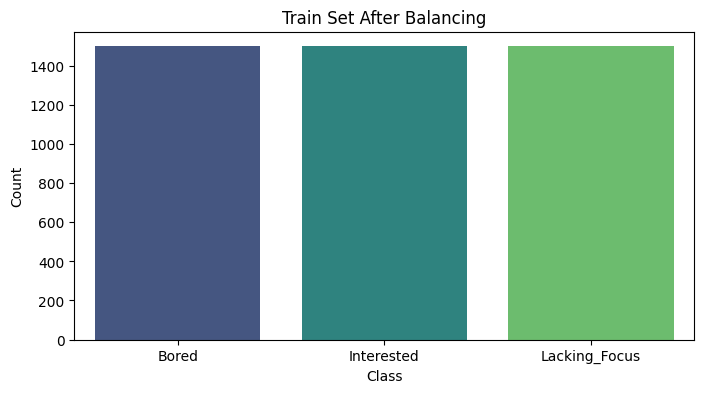

In [208]:
# Plot After Balancing
plot_class_distribution(balanced_train_df, "Train Set After Balancing")

In [210]:
# Combine Balanced Train Data with Validation & Test Data
final_df = pd.concat([balanced_train_df, val_df, test_df])

# Save to CSV (Applied condition)
if not os.path.exists(OUTPUT_METADATA):
    final_df.to_csv(OUTPUT_METADATA, index=False)
    print(f"Metadata saved to {OUTPUT_METADATA}")
else:
    print(f"{OUTPUT_METADATA} already exists. Skipping save.")

/mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/processed/balanced_metadata.csv already exists. Skipping save.


### 4. Organizing Balanced Dataset: Copying Train, Validation, and Test Data to a Balance_Processed Folder

In [211]:
# Read the balanced_metadata csv and show first 5 rows
balanced_df = pd.read_csv(OUTPUT_METADATA)
print(balanced_df.head())

          clip_id emotion  split  frames  \
0  1100021015.avi   Bored  Train      50   
1  1100022001.avi   Bored  Train      50   
2  1100022002.avi   Bored  Train      50   
3  1100022003.avi   Bored  Train      50   
4  1100022004.avi   Bored  Train      50   

                                                path  
0  /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/dat...  
1  /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/dat...  
2  /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/dat...  
3  /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/dat...  
4  /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/dat...  


In [212]:
# Create a balanced df split for easily applied to other row
balanced_df_train = balanced_df[balanced_df["split"] == "Train"]
balanced_df_val = balanced_df[balanced_df["split"] == "Validation"]
balanced_df_test = balanced_df[balanced_df["split"] == "Test"]

In [213]:
# Check for the class split
print("Train Class Distribution:")
print(balanced_df_train["emotion"].value_counts())

print("\nValidation Class Distribution:")
print(balanced_df_val["emotion"].value_counts())

print("\nTest Class Distribution:")
print(balanced_df_test["emotion"].value_counts())

Train Class Distribution:
emotion
Bored            1500
Interested       1500
Lacking_Focus    1500
Name: count, dtype: int64

Validation Class Distribution:
emotion
Interested       629
Bored            411
Lacking_Focus    220
Name: count, dtype: int64

Test Class Distribution:
emotion
Interested       1111
Bored             287
Lacking_Focus     189
Name: count, dtype: int64


In [214]:
# Initialize balanced dataset directories
train_dir = os.path.join(BALANCED_DIR, "Train")
val_dir = os.path.join(BALANCED_DIR, "Validation")
test_dir = os.path.join(BALANCED_DIR, "Test")

# Create directories
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Print the directories that has been created
print("Balanced Train directory:", train_dir)
print("Balanced Validation directory:", val_dir)
print("Balanced Test directory:", test_dir)

Balanced Train directory: /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train
Balanced Validation directory: /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Validation
Balanced Test directory: /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Test


In [224]:
# Function to copy a single file
def copy_folder(src_folder, emotion, target_dir):
    base_name = os.path.basename(src_folder)
    dest_folder = os.path.join(target_dir, emotion, base_name)

    # If folder exists, create a unique duplicate folder
    counter = 1
    while os.path.exists(dest_folder):
        dest_folder = os.path.join(target_dir, emotion, f"{base_name}_dup{counter}")
        counter += 1

    shutil.copytree(src_folder, dest_folder)

# Function to move images using multi-threading into balance_processed file
def backup_to_target_dir(metadata_df, target_dir, max_workers=8):
    os.makedirs(target_dir, exist_ok=True)

    # Create emotion subdirectories
    emotions = metadata_df["emotion"].unique()
    for emotion in emotions:
        os.makedirs(os.path.join(target_dir, emotion), exist_ok=True)

    # Use ThreadPoolExecutor for parallel copying
    with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = [
            executor.submit(copy_folder, file_path, emotion, target_dir) 
            for file_path, emotion in zip(metadata_df["path"], metadata_df["emotion"])
        ]

        # Show progress bar
        for _ in tqdm(concurrent.futures.as_completed(futures), 
                      total=len(metadata_df), 
                      desc=f"Copying files to {target_dir}", 
                      unit="file"):
            pass

# Backup the subfolders into their respective splits
backup_to_target_dir(balanced_df_train, train_dir)
backup_to_target_dir(balanced_df_val, val_dir)
backup_to_target_dir(balanced_df_test, test_dir)

print("Balanced dataset stored in:", BALANCED_DIR)

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train: 100%|██████████| 4500/4500 [17:29<00:00,  4.29file/s]
Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Validation: 100%|██████████| 1260/1260 [05:00<00:00,  4.19file/s]
Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Test: 100%|██████████| 1587/1587 [07:03<00:00,  3.75file/s]

Balanced dataset stored in: /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed


### 5. DAiSEE Dataset Model Train & Evaluation (by using Tensorflow & Keras)

##### 5.1 Configure GPU meomory

In [225]:
# Configure gpu memory
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    for device in physical_devices:
        tf.config.experimental.set_memory_growth(device, True)

# Print activated devices        
print(physical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


##### 5.2 Data Generator Preparation

In [226]:
# Helper function to check the class distribution
def print_class_distribution(labels):
    unique, counts = np.unique(labels, return_counts=True)
    total = len(labels) 
    print("Class Distribution:") 
    for cls, count in zip(unique, counts): 
        percentage = (count / total) * 100 
        print(f"Class {cls}: {count} samples ({percentage:.2f}%)")

In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range=15,  
    width_shift_range=0.05,  
    height_shift_range=0.05,  
    zoom_range=0.1,  
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],  
    shear_range=0.05,  
    fill_mode='nearest',  
    preprocessing_function=preprocess_input
)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_dir, 
    target_size=(224, 224), 
    batch_size=32, 
    class_mode='categorical', 
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    val_dir, target_size=(224, 224), 
    batch_size=32, 
    class_mode='categorical', 
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir, 
    target_size=(224, 224), 
    batch_size=32, 
    class_mode='categorical', 
    shuffle=False
)

Found 225000 images belonging to 3 classes.
Found 63000 images belonging to 3 classes.
Found 79350 images belonging to 3 classes.


In [228]:
# Print class distribution for train generator
print("\nTraining Data Class Distribution:")
train_labels = train_generator.classes
print_class_distribution(train_labels)

# Optionally, print for validation and test generators
print("\nValidation Data Class Distribution:")
val_labels = val_generator.classes
print_class_distribution(val_labels)

print("\nTest Data Class Distribution:")
test_labels = test_generator.classes
print_class_distribution(test_labels)


Training Data Class Distribution:
Class Distribution:
Class 0: 75000 samples (33.33%)
Class 1: 75000 samples (33.33%)
Class 2: 75000 samples (33.33%)

Validation Data Class Distribution:
Class Distribution:
Class 0: 20550 samples (32.62%)
Class 1: 31450 samples (49.92%)
Class 2: 11000 samples (17.46%)

Test Data Class Distribution:
Class Distribution:
Class 0: 14350 samples (18.08%)
Class 1: 55550 samples (70.01%)
Class 2: 9450 samples (11.91%)


#### 5.3 Warmup + Cosine Decay Implementation

In [246]:
# Initialize the necessary variables
initial_lr = 1e-3 
target_lr = 1e-5   
warmup_epochs = 3  
steps_per_epoch = len(train_generator)
epochs = 30

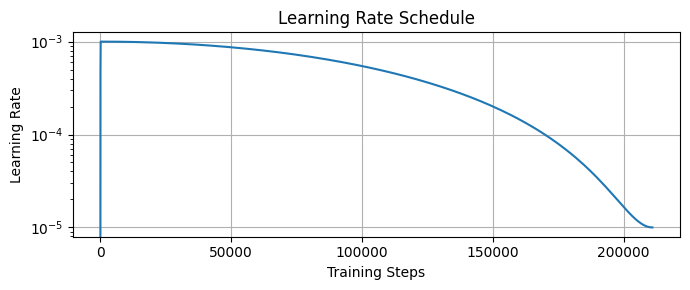

In [267]:
class WarmupCosineDecay(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, initial_lr, target_lr, warmup_epochs, total_epochs, steps_per_epoch):
        super().__init__()
        
        if steps_per_epoch is None:
            raise ValueError("steps_per_epoch must be provided")
        
        self.initial_lr = initial_lr
        self.target_lr = target_lr
        self.total_steps = total_epochs * steps_per_epoch
        self.warmup_steps = warmup_epochs * steps_per_epoch
    
    def __call__(self, step):
        step = tf.cast(step, tf.float32)
        
        # Linear warmup
        warmup_lr = self.initial_lr * tf.minimum(step / self.warmup_steps, 1.0)
        
        # Cosine decay
        def cosine_decay_fn():
            decay_steps = self.total_steps - self.warmup_steps
            progress = (step - self.warmup_steps) / decay_steps
            cosine_decayed = 0.5 * (1 + tf.math.cos(np.pi * progress))
            return self.target_lr + (self.initial_lr - self.target_lr) * cosine_decayed
        
        return tf.cond(
            step < self.warmup_steps, 
            lambda: warmup_lr, 
            cosine_decay_fn
        )
    
    def get_config(self):
        return {
            "initial_lr": self.initial_lr,
            "target_lr": self.target_lr,
            "total_steps": self.total_steps,
            "warmup_steps": self.warmup_steps
        }

# Visualization function to help understand the learning rate schedule
def plot_lr_schedule(lr_schedule, total_epochs, steps_per_epoch):
    total_steps = total_epochs * steps_per_epoch
    steps = np.arange(total_steps)
    lrs = [lr_schedule(step) for step in steps]
    
    plt.figure(figsize=(7, 3))
    plt.plot(steps, lrs)
    plt.title('Learning Rate Schedule')
    plt.xlabel('Training Steps')
    plt.ylabel('Learning Rate')
    plt.yscale('log')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Example usage
lr_schedule = WarmupCosineDecay(initial_lr, target_lr, warmup_epochs, steps_per_epoch, epochs)

# Visualize the learning rate schedule
plot_lr_schedule(lr_schedule, epochs, steps_per_epoch)

#### 5.4 Build ResNet50 model architecture

In [344]:
# Leverage ResNet50 weights without including output layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze first 80 layer to perform training
for layer in base_model.layers[:80]:  
    layer.trainable = False  
for layer in base_model.layers[80:]:  
    layer.trainable = True

In [ ]:
x = base_model.output
x = GlobalAveragePooling2D()(x)

x = Dense(256, kernel_regularizer=l2(0.001))(x)  
x = BatchNormalization()(x)  
x = ReLU()(x)
x = Dropout(0.5)(x)

x = Dense(128, kernel_regularizer=l2(0.001))(x)  
x = BatchNormalization()(x) 
x = ReLU()(x)
x = Dropout(0.4)(x)

predictions = Dense(3, activation='softmax')(x)

In [ ]:
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(
    optimizer = Adam(learning_rate=lr_schedule),
    loss = CategoricalFocalCrossentropy(gamma=2),  
    metrics = ['accuracy', Precision(name='precision'), Recall(name='recall')]
)

#### 5.5 Train the DAiSEE dataset into ResNet50 model

In [347]:
# Add callbacks features to ensuring can stop early if the accuracy didnt make improvement for both ModelCheckpoint and EarlyStopping for epochs
checkpoint_path = os.path.join(MODEL_DIR, 'best_model.weights.h5')

callbacks = [
            ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, save_weights_only=True, mode='max', verbose=1),
            EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True, verbose=1)
        ]

In [353]:
# Start training the model
print("--------------Training Pharse Started--------------\n")

history = model.fit(
            train_generator,
            steps_per_epoch=steps_per_epoch,
            validation_data=val_generator,
            validation_steps=len(val_generator),
            epochs=epochs,
            callbacks=callbacks,
            verbose=1,
        )

--------------Training Pharse Started--------------

Epoch 1/30
7032/7032 ━━━━━━━━━━━━━━━━━━━━ 0s 777ms/step - accuracy: 0.5127 - loss: 0.1274 - precision: 0.6219 - recall: 0.1581

KeyboardInterrupt: 

#### 5.6 Save the Trained Model

In [ ]:
if not os.path.exists(os.path.dirname(EMOTIONAL_RECOGNITION_MODEL)):
    os.makedirs(os.path.dirname(EMOTIONAL_RECOGNITION_MODEL))
    
model.save(EMOTIONAL_RECOGNITION_MODEL)
print(f"Model saved to {EMOTIONAL_RECOGNITION_MODEL}")

#### 5.7 Model Evaluation (with load the Trained Model)

In [ ]:
# Load the trained model
model_path = os.path.dirname(EMOTIONAL_RECOGNITION_MODEL)
model = load_model(model_path)
print(f"Model load successfully from {EMOTIONAL_RECOGNITION_MODEL}")

In [ ]:
# Get true labels from the test generator
y_true = test_generator.classes  
class_names = list(test_generator.class_indices.keys())

# Predict all test samples in one go (no manual looping)
y_pred_probs = model.predict(test_generator, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)

In [ ]:
# Generate Classification report
report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

In [ ]:
# Compute Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

# Compute Recall per class
recall_per_class = recall_score(y_true, y_pred, average=None)
for idx, emotion in enumerate(class_names):
    print(f"Recall ({emotion}): {recall_per_class[idx]:.4f}")

# Calculate accuracy manually
accuracy = np.mean(y_true == y_pred)
print(f"\nTest Accuracy: {accuracy:.4f}")

In [ ]:
# Save evaluation metrics to CSV
metrics_df = pd.DataFrame(report).transpose()
metrics_path = os.path.join(MODEL_DIR, 'evaluation_metrics.csv')
metrics_df.to_csv(metrics_path)
print(f"Detailed metrics saved to {metrics_path}")